In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow_addons.callbacks import TQDMProgressBar
from scipy.special import softmax

from vae import VAE, compute_mixture

In [2]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

# Scale to be between [-1, 1]
x_train = (x_train.astype('float32') - 127.5) / 127.5
x_test = (x_test.astype('float32') - 127.5) / 127.5

print(x_train.shape)

mnist_digits = x_train
mnist_digits = np.expand_dims(mnist_digits, -1)

mnist_digits_test = x_test
mnist_digits_test = np.expand_dims(mnist_digits_test, -1)

(60000, 28, 28)


[-1.         -1.         -1.         -0.3647059   0.88235295  0.9843137
  0.9843137  -0.06666667 -0.8039216  -1.        ]


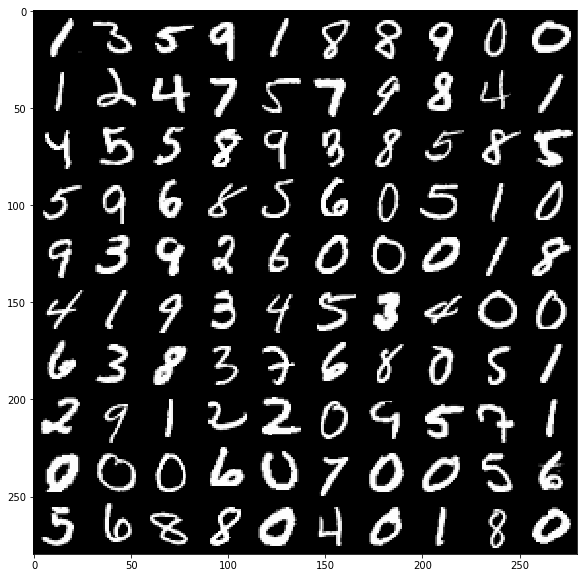

In [3]:
def display_digits(X, digit_size=28, n=10):
    figure = np.zeros((digit_size * n, digit_size * n))
    
    for i in range(n):
        for j in range(n):
            index = np.random.randint(0, X.shape[0])
            digit = X[index].reshape(digit_size, digit_size)
            
            x = i * digit_size
            y = j * digit_size
            figure[x:x + digit_size, y:y + digit_size] = digit
    
    plt.figure(figsize=(max(n, 3), max(n, 3)))
    plt.imshow(figure, cmap='Greys_r')
    plt.show()
    

print(mnist_digits[0, 14, 10:20].reshape(10))
display_digits(mnist_digits)

In [4]:
n_components = 3
vae = VAE(latent_dim=50, mixture_components=n_components)
vae.encoder.summary()
vae.decoder.summary()
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
res1c_branch2a (Conv2D)         (None, 28, 28, 64)   128         input_1[0][0]                    
__________________________________________________________________________________________________
bn1c_branch2a (BatchNormalizati (None, 28, 28, 64)   256         res1c_branch2a[0][0]             
__________________________________________________________________________________________________
activation_6 (Activation)       (None, 28, 28, 64)   0           bn1c_branch2a[0][0]              
____________________________________________________________________________________________

In [5]:
history = vae.fit(mnist_digits, epochs=6, batch_size=128,
                  validation_data=(mnist_digits_test, None),
                  callbacks=[TQDMProgressBar()], verbose=0)

Epoch 1/6



Epoch 2/6



Epoch 3/6



Epoch 4/6



Epoch 5/6



Epoch 6/6


In [6]:
history.history

{'loss': [813.2633666992188,
  743.7587890625,
  705.9732055664062,
  738.9850463867188,
  684.3526611328125,
  708.2711181640625],
 'reconstruction_loss': [805.68359375,
  735.235107421875,
  696.8693237304688,
  729.3903198242188,
  674.8057250976562,
  698.8881225585938],
 'kl_loss': [2.526588201522827,
  2.84122633934021,
  3.0346341133117676,
  3.1982433795928955,
  3.182312250137329,
  3.1276612281799316],
 'val_loss': [792.3558349609375,
  728.6605224609375,
  739.2334594726562,
  739.9085083007812,
  669.845458984375,
  698.0635375976562],
 'val_reconstruction_loss': [789.4193115234375,
  725.336181640625,
  735.714599609375,
  736.30615234375,
  666.0381469726562,
  694.2200927734375],
 'val_kl_loss': [2.9365015029907227,
  3.32435941696167,
  3.5188686847686768,
  3.6023387908935547,
  3.8073339462280273,
  3.8434531688690186]}

In [7]:
# Save model
vae.encoder.save('vae-encoder')
vae.decoder.save('vae-decoder')

enc = keras.models.load_model('vae-encoder')
dec = keras.models.load_model('vae-decoder')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: vae-encoder/assets
INFO:tensorflow:Assets written to: vae-decoder/assets


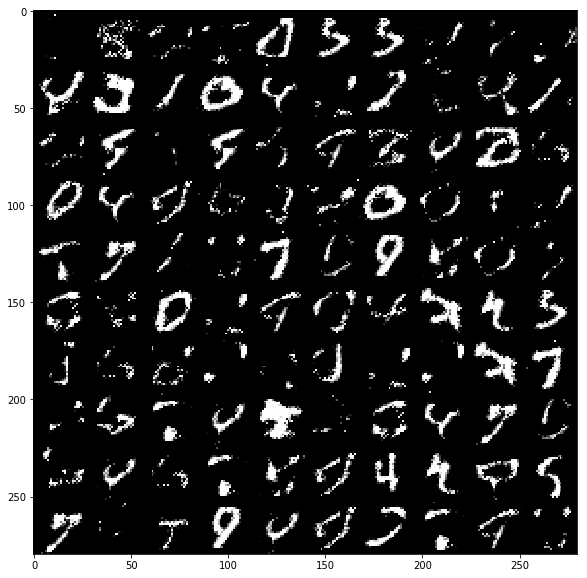

In [8]:
# Test decoder
num_samples = 100
output = dec.predict(np.random.normal(size=(num_samples, 50)))
img = np.zeros(shape=(num_samples, 1, 28, 28))
for index in range(num_samples):
    m = output[index, :, :, :n_components]
    invs = output[index, :, :, n_components:2*n_components]
    logit_weights = output[index, :, :, 2*n_components:3*n_components]
    weights = softmax(logit_weights[:, :, :], axis=-1)
    
    # Compute pixel distribution and sample
    pvals = compute_mixture(m, invs, weights, n_components)
    for i in range(img[0].shape[1]):
        for j in range(img[0].shape[1]):
            ps = pvals[i, j, :] + 1e-6
            ps /= np.sum(ps)
            img[index, 0, i, j] = np.argmax(np.random.multinomial(1, ps))
            
display_digits(img)

In [9]:
# Test encoder
output = enc.predict(x_test[10:11, :, :])
mean = output[0]
log_var = output[1]
print(mean.shape, log_var.shape)
print(mean[0, :5])
print(log_var[0, :5])

(1, 50) (1, 50)
[ 0.6714549  -0.9190788  -0.1547409   0.10204057  0.29495943]
[-7.41395  -8.355218 -6.967768 -7.768272 -7.335691]
